<a href="https://colab.research.google.com/github/menguri/Ubiquant_Expectiing/blob/main/Check_correlation%26Baseline_lgbm(Bronze_Medal).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **✔ Data Loading & Import**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

This notebook introduces dataset and code converted from train.csv to pickle file.
It takes less than a minute to load all the data, and the data size reduce from 18.5GB to 3.6GB.

dataset URL : [https://www.kaggle.com/columbia2131/ump-train-picklefile](https://www.kaggle.com/columbia2131/ump-train-picklefile)

In [ ]:
def transform_csv2pickle(path, usecols, dtype):
    train = pd.read_csv(
        path,
        usecols=usecols,
        dtype=dtypes
    )
    train.to_pickle('train.pkl')


path = '../input/ubiquant-market-prediction/train.csv'

basecols = ['row_id', 'time_id', 'investment_id', 'target']
features = [f'f_{i}' for i in range(300)]

dtypes = {
    'row_id': 'str',
    'time_id': 'uint16',
    'investment_id': 'uint16',
    'target': 'float32',
}
for col in features:
    dtypes[col] = 'float32'

# transform_csv2pickle(path, basecols+features, dtypes)

In [ ]:
%%time
train = pd.read_pickle('../input/ump-train-picklefile/train.pkl')

CPU times: user 1.58 s, sys: 4.92 s, total: 6.51 s
Wall time: 35.7 s


In [ ]:
start_mem = train.memory_usage().sum() / 1024**2

for col in train.columns:
    col_type = train[col].dtype

    if col_type != object:
        c_min = train[col].min()
        c_max = train[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                train[col] = train[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                train[col] = train[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                train[col] = train[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                train[col] = train[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                train[col] = train[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                train[col] = train[col].astype(np.float32)
            else:
                train[col] = train[col].astype(np.float64)
    else:
        train[col] = train[col].astype('category')

end_mem = train.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%


In [ ]:
# DATA_PATH = Path('../input/ump-train-picklefile')
# SAMPLE_TEST_PATH = Path('../input/ubiquant-market-prediction')
# !ls $SAMPLE_TEST_PATH

# **🙄 Simple EDA**

**About train...**

In [ ]:
display(train.info())
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(303)
memory usage: 1.9 GB


None

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [ ]:
len(train)

3141410

In [ ]:
# row_id
# time_id
# investment_id
# target
# f_0 - f_299

train.columns

Index(['row_id', 'time_id', 'investment_id', 'target', 'f_0', 'f_1', 'f_2',
       'f_3', 'f_4', 'f_5',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=304)

**Target Mean**

Let's see how target values change

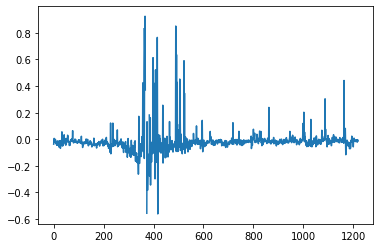

In [ ]:
# Groupby time
# target values in Specific time[380 - 550] have large Volatility
dic = {}
for i in range(0, 1220):
    train_time = train['target'][train['time_id'] == i].mean()
    dic[f'{i}'] = train_time


time_df = pd.Series(dic)
del dic

time_df.plot()
plt.show()

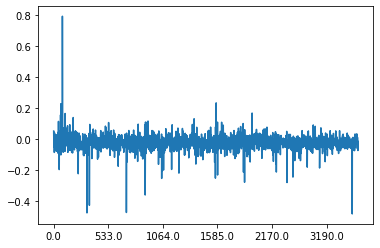

In [ ]:
# Groupby Investment_id
dic = {}
for i in list(set(list(train['investment_id']))):
    train_invest_id = train['target'][train['investment_id'] == i].mean()
    dic[f'{i}'] = train_invest_id


train_invest_id_df = pd.Series(dic)
del dic

train_invest_id_df.plot()
plt.show()

# **🤞 Correlation**

**Step 1 : just Correlation & Target**

**Check Correlation target & f_0 - f_300**

humm... can't find something special variable. 
they all have just low correlation with target

In [ ]:
# Correlation
dic = {}

for i in range(0, 300):
    corr_f = train[['target', f'f_{i}']].corr().iloc[0,1]
    print(f'target & f_{i} Correlation is {corr_f}')
    dic[f'f_{i}'] = corr_f

del dic

target & f_0 Correlation is 0.009622624518008669
target & f_1 Correlation is -0.015878122220306722
target & f_2 Correlation is 0.02411954207564331
target & f_3 Correlation is -0.03453516890073399
target & f_4 Correlation is -0.0053177881001054425
target & f_5 Correlation is 0.03082517839871968
target & f_6 Correlation is -0.01372654579056958
target & f_7 Correlation is -0.0014738864451799597
target & f_8 Correlation is 0.023749732423903654
target & f_9 Correlation is -0.020845647091986254
target & f_10 Correlation is 0.013776362641494207
target & f_11 Correlation is 0.016860014598799867
target & f_12 Correlation is 0.008960248706712826
target & f_13 Correlation is -0.004795530864366416
target & f_14 Correlation is -0.019423618429999706
target & f_15 Correlation is -0.043520741419668274
target & f_16 Correlation is -0.03193905937504301
target & f_17 Correlation is 0.03424964179309064
target & f_18 Correlation is 0.013009773836214709
target & f_19 Correlation is -0.010292059888858658
tar

**Step 2 : Correlation & Target -> Groupby investment_id**

each investment_id have different target&f_i relationship.

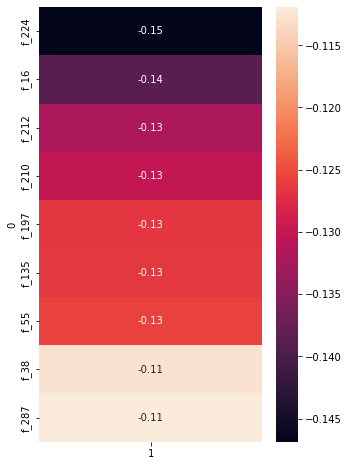

In [ ]:
# Correlation - investment_id = 0
dic = {}

for i in range(0, 300):
    corr_f = train[['target', f'f_{i}']][train['investment_id'] == 0].corr().iloc[0,1]
    #print(f'target & f_{i} Correlation is {corr_f}')
    dic[f'f_{i}'] = corr_f

sorted_dict = sorted(dic.items(), key = lambda item: item[1])

plt.figure(figsize=(5,8))
sns.heatmap(pd.DataFrame(sorted_dict[1:10]).set_index(0).head(30), annot=True)

del dic
del sorted_dict

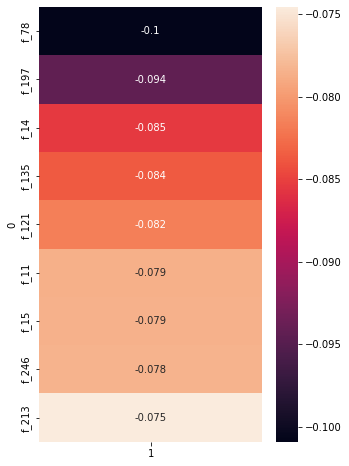

In [ ]:
# Correlation - investment_id = 1
dic = {}

for i in range(0, 300):
    corr_f = train[['target', f'f_{i}']][train['investment_id'] == 1].corr().iloc[0,1]
    #print(f'target & f_{i} Correlation is {corr_f}')
    dic[f'f_{i}'] = corr_f

sorted_dict = sorted(dic.items(), key = lambda item: item[1])

plt.figure(figsize=(5,8))
sns.heatmap(pd.DataFrame(sorted_dict[1:10]).set_index(0).head(30), annot=True)

del dic
del sorted_dict

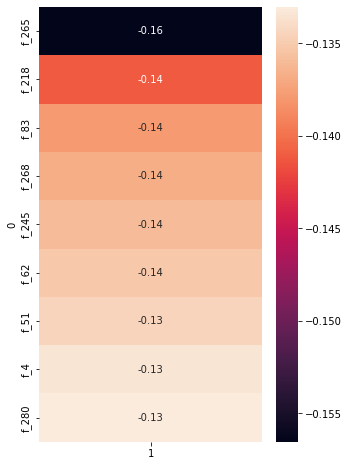

In [ ]:
# Correlation - investment_id = 2
dic = {}

for i in range(0, 300):
    corr_f = train[['target', f'f_{i}']][train['investment_id'] == 2].corr().iloc[0,1]
    #print(f'target & f_{i} Correlation is {corr_f}')
    dic[f'f_{i}'] = corr_f

sorted_dict = sorted(dic.items(), key = lambda item: item[1])

plt.figure(figsize=(5,8))
sns.heatmap(pd.DataFrame(sorted_dict[1:10]).set_index(0).head(30), annot=True)

del dic
del sorted_dict

**Step 3 : target's relationship with investment_id**

humm... what the fuxk. 😫😨🤯🥵😱😡👿

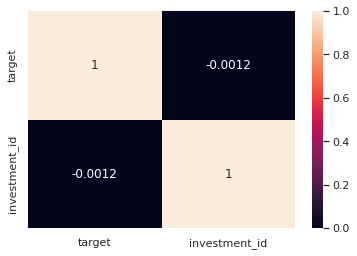

In [ ]:
target_invest = train[['target', 'investment_id']].copy()
target_invest_corr = target_invest.corr()

sns.set_theme()
sns.heatmap(target_invest_corr, annot=True)

del target_invest
del target_invest_corr

# **Baseline (LGBM & xgboost)**

Ok. Lets go to make Baseline 🎈

In [ ]:
import lightgbm
import xgboost
from sklearn.model_selection import train_test_split

In [ ]:
x = train.drop(['row_id', 'time_id', 'target'], axis=1).copy()
y = train.target
display(x.head())
display(y.head())

,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1.0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,0.114807,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,2.0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,0.114807,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,6.0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,0.114807,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,7.0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,0.114807,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,8.0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,0.114807,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

split train/test -> train/val/test

In [ ]:
line = len(train)//10
x_test = x[:line]
y_test = y[:line]
x_val = x[line:line*2]
y_val = y[line:line*2]
x_train = x[line*2:]
y_train = y[line*2:]

print(f'train : {len(x_train)} / val : {len(x_val)} / test : {len(x_test)}')

train : 2513128 / val : 314141 / test : 314141


**LGBM model**

In [ ]:
train_ds = lightgbm.Dataset(x_train, label = y_train) 
val_ds = lightgbm.Dataset(x_val, label = y_val) 

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 5, 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144}

In [ ]:
model = lightgbm.train(params, train_ds, 100, val_ds)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.128062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76755
[LightGBM] [Info] Number of data points in the train set: 2513128, number of used features: 301
[LightGBM] [Info] Start training from score -0.020118
[1]	valid_0's l2: 0.857889
[2]	valid_0's l2: 0.857739
[3]	valid_0's l2: 0.857591
[4]	valid_0's l2: 0.857444
[5]	valid_0's l2: 0.857305
[6]	valid_0's l2: 0.857179
[7]	valid_0's l2: 0.857043
[8]	valid_0's l2: 0.856921
[9]	valid_0's l2: 0.856792
[10]	valid_0's l2: 0.856665
[11]	valid_0's l2: 0.856543
[12]	valid_0's l2: 0.85642
[13]	valid_0's l2: 0.856312
[14]	valid_0's l2: 0.8562
[15]	valid_0's l2: 0.856087
[16]	valid_0's l2: 0.855976
[17]	valid_0's l2: 0.855873
[18]	valid_0's l2: 0.855769
[19]	valid_0's l2: 0.855664
[20]	valid_0's l2: 0.855565
[21]	valid_0's l2: 0.855457
[22]	valid_0's l2: 0.855355
[23]	valid_0's l2: 0.855259
[24]	valid_0's l2:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

prediction = model.predict(x_test)
mse = mean_squared_error(y_test, prediction)
print(f'model mse is {mse}')

model mse is 0.8744314977417298


In [ ]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    test_df.drop(['row_id'], axis=1, inplace=True)
    pred = model.predict(test_df)
    sample_prediction_df['target'] = pred
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
